In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# EDA

This resort is our largest ski resort in both capacity and the population area center close to the resort. 

A couple notes on getting the data for this particular ski area: 

* `SCHOOL_OUT` is if the public school district did not have class on a day that normally would have school (weekday). Examples include winter break, MLK Day, and teacher prep days. Weekends surrounding school closures such as Thanksgiving, Presidents Day, were not counted as a school out day. I was able to source this from the school district website. 
* Mountain Weather Data was gathered from a NOAA weather station on the mountain the resort is located, however this weather station is on a different face of the mountain and sometimes different aspects of this mountain can experience differences in weather, especially in snow and wind. 
* Wind data was not availible from the mountain weather station although my contact at the resort mentioned wind is a key factor in detering visitors or sometimes closing down the resort.

We'll first load the dataset and do some cleaning and exploration. 


### After cleaning stas

- Dataset count: 851

Daily Visitors stats:

mean     2869.439483

std      2013.683973

min       118.000000

25%      1299.000000

50%      2317.000000

75%      4062.500000

max      8719.000000

In [133]:
#Load the dataset, take a look at the data info: 
df_3 = pd.read_csv('Data/Resort_3_data.csv', thousands=',')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          851 non-null    object 
 1   IS_HOLIDAY    851 non-null    int64  
 2   SCHOOL_OUT    851 non-null    int64  
 3   DAY_VISITS    851 non-null    int64  
 4   NIGHT_VISITS  851 non-null    int64  
 5   TOTAL_VISITS  851 non-null    int64  
 6   M_PRCP        851 non-null    float64
 7   M_SNWD        851 non-null    int64  
 8   M_TAVG        851 non-null    int64  
 9   M_TMAX        851 non-null    int64  
 10  M_TMIN        851 non-null    int64  
 11  T_AWND        851 non-null    float64
 12  T_PRCP        851 non-null    float64
 13  T_SNOW        851 non-null    float64
 14  T_TAVG        851 non-null    int64  
 15  T_TMAX        851 non-null    int64  
 16  T_TMIN        851 non-null    int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 113.1+ KB


See if there's any duplicate dates:

In [134]:
df_3.duplicated().value_counts()

False    851
dtype: int64

Make the `Date` column a datetime object, create day of week and month category, we'll use these variables in our models to see if they have any predictive power.

In [135]:
#make the 'Date' Column a datetime type
df_3['Date'] = pd.to_datetime(df_3['Date'])

#The day_of_week_num column created with Monday=0, Sunday=6. Weekends = 5 & 6, Friday = 4
df_3['day_of_week_num'] = df_3['Date'].dt.dayofweek

#The month column created
df_3['Month'] = df_3['Date'].dt.month


print(df_3['day_of_week_num'].value_counts())
print(df_3['Month'].value_counts())

5    136
6    135
4    130
3    113
2    113
0    113
1    111
Name: day_of_week_num, dtype: int64
1     185
12    174
3     170
2     169
4     117
11     18
5      18
Name: Month, dtype: int64


Checking to see if there's any outliers or interesting info we can learn from the stats: 

In [136]:
df_3.describe()

,IS_HOLIDAY,SCHOOL_OUT,DAY_VISITS,NIGHT_VISITS,TOTAL_VISITS,M_PRCP,M_SNWD,M_TAVG,M_TMAX,M_TMIN,T_AWND,T_PRCP,T_SNOW,T_TAVG,T_TMAX,T_TMIN,day_of_week_num,Month
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,0.042303,0.125734,2367.911868,1711.804935,2869.439483,0.407403,88.408931,31.263220,36.383079,26.506463,8.163561,0.142256,0.044418,44.991774,51.944771,38.554642,3.156287,4.555817
std,0.201398,0.331745,1610.007266,1418.912395,2013.683973,0.546199,37.409966,7.049325,8.000229,6.903598,4.325198,0.235899,0.418739,7.097716,9.087963,6.595382,2.012378,4.099368
min,0.000000,0.000000,42.000000,0.000000,118.000000,0.000000,9.000000,12.000000,15.000000,5.000000,0.890000,0.000000,0.000000,22.000000,28.000000,11.000000,0.000000,1.000000
25%,0.000000,0.000000,1177.000000,628.000000,1299.000000,0.000000,64.000000,27.000000,31.000000,22.000000,4.700000,0.000000,0.000000,40.000000,46.000000,34.000000,1.000000,2.000000
50%,0.000000,0.000000,1924.000000,1247.000000,2317.000000,0.200000,92.000000,31.000000,35.000000,26.000000,7.610000,0.030000,0.000000,45.000000,51.000000,39.000000,3.000000,3.000000
75%,0.000000,0.000000,3282.500000,2415.500000,4062.500000,0.600000,114.000000,35.000000,41.000000,31.000000,10.850000,0.200000,0.000000,49.000000,57.000000,43.000000,5.000000,4.000000
max,1.000000,1.000000,7120.000000,6135.000000,8719.000000,3.500000,177.000000,59.000000,67.000000,53.000000,29.530000,2.190000,6.500000,71.000000,90.000000,55.000000,6.000000,12.000000


Looking for any *null* or *NAN* values 

In [137]:
df_3.isna().sum()

Date               0
IS_HOLIDAY         0
SCHOOL_OUT         0
DAY_VISITS         0
NIGHT_VISITS       0
TOTAL_VISITS       0
M_PRCP             0
M_SNWD             0
M_TAVG             0
M_TMAX             0
M_TMIN             0
T_AWND             0
T_PRCP             0
T_SNOW             0
T_TAVG             0
T_TMAX             0
T_TMIN             0
day_of_week_num    0
Month              0
dtype: int64

# Correlation Matrix 
Let's start exploring correlation, taking out `TOTAL_VISITS` (our target), SP, Day and Night related ticket totals to see if any of our variables are highly correlated. Also taking out `Date` as the specific date is not a predictor. 


In [138]:
#removing columns for correlation testing

df_3_corr = df_3.drop(columns=['Date', 'TOTAL_VISITS', 'DAY_VISITS', 'NIGHT_VISITS'])
df_3_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IS_HOLIDAY       851 non-null    int64  
 1   SCHOOL_OUT       851 non-null    int64  
 2   M_PRCP           851 non-null    float64
 3   M_SNWD           851 non-null    int64  
 4   M_TAVG           851 non-null    int64  
 5   M_TMAX           851 non-null    int64  
 6   M_TMIN           851 non-null    int64  
 7   T_AWND           851 non-null    float64
 8   T_PRCP           851 non-null    float64
 9   T_SNOW           851 non-null    float64
 10  T_TAVG           851 non-null    int64  
 11  T_TMAX           851 non-null    int64  
 12  T_TMIN           851 non-null    int64  
 13  day_of_week_num  851 non-null    int64  
 14  Month            851 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 99.9 KB


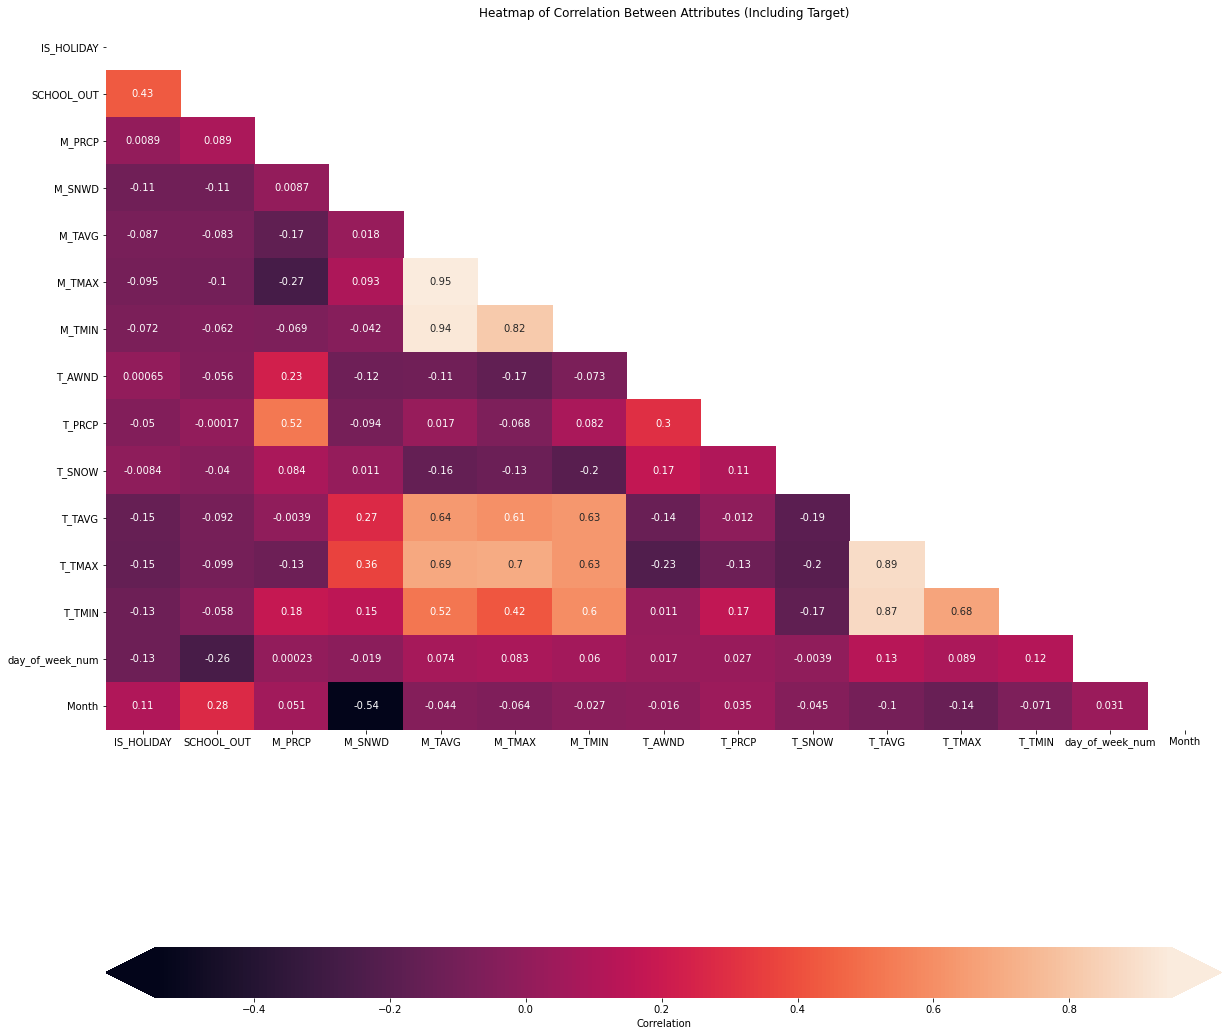

In [139]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = df_3_corr
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)), ax=ax, annot=True, 
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [140]:
#identifying the highest correlated variables

df = df_3_corr.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]


,cc
pairs,
"(M_TAVG, M_TMAX)",0.949567
"(M_TMIN, M_TAVG)",0.937526
"(T_TAVG, T_TMAX)",0.888021
"(T_TMIN, T_TAVG)",0.874355
"(M_TMAX, M_TMIN)",0.821008


### Multicollinairity decision

Based on the information above it makes sense to drop:

- Mountain Max Temperature (`M_TMAX`)
- Mountain Min Temperature (`M_TMIN`)
- Town Min Temperature (`T_MIN`)
- Town Max Temperature (`T_MAX`)

**Ticketing:**

To keep things simple I think for now I am going to remove the ticketing and visit informatoin that breaks down season pass vs ticket and night vs day ticketing. I may want to use these as a prediction if there's time or the business need becomes obvious. Unfortunately I don't have pre-sale data to work with. 

- `DAY_VISITS`
- `NIGHT_VISITS`

In [141]:
df_3_preprocessed = df_3.drop(columns=['M_TMAX', 'M_TMIN', 'T_TMAX', 'T_TMIN', 'DAY_VISITS', 'NIGHT_VISITS'])
df_3_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             851 non-null    datetime64[ns]
 1   IS_HOLIDAY       851 non-null    int64         
 2   SCHOOL_OUT       851 non-null    int64         
 3   TOTAL_VISITS     851 non-null    int64         
 4   M_PRCP           851 non-null    float64       
 5   M_SNWD           851 non-null    int64         
 6   M_TAVG           851 non-null    int64         
 7   T_AWND           851 non-null    float64       
 8   T_PRCP           851 non-null    float64       
 9   T_SNOW           851 non-null    float64       
 10  T_TAVG           851 non-null    int64         
 11  day_of_week_num  851 non-null    int64         
 12  Month            851 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 86.6 KB


0 visit days: Taking a look at rows with 0 visits (these would be either an error or a the resort is closed)

In [142]:
df_3_preprocessed[df_3_preprocessed.TOTAL_VISITS == 0]

,Date,IS_HOLIDAY,SCHOOL_OUT,TOTAL_VISITS,M_PRCP,M_SNWD,M_TAVG,T_AWND,T_PRCP,T_SNOW,T_TAVG,day_of_week_num,Month


No 0 Visit Days like the other resorts, yay!

## Indexing with Date

Making the Date the Index so it A) doesn't get mis-interpreted as a predictor in our modeling and B) so we can visualze our data better

In [143]:
#df_3_preprocessed.reset_index(inplace=True)
df_3_preprocessed.set_index('Date', inplace=True)
df_3_preprocessed.head()


,IS_HOLIDAY,SCHOOL_OUT,TOTAL_VISITS,M_PRCP,M_SNWD,M_TAVG,T_AWND,T_PRCP,T_SNOW,T_TAVG,day_of_week_num,Month
Date,,,,,,,,,,,,
2015-11-21,0,0,588,0.0,12,36,4.92,0.00,0.0,44,5,11
2015-11-27,0,1,1196,0.0,11,35,6.26,0.00,0.0,36,4,11
2015-11-28,0,0,1668,0.0,11,38,9.17,0.00,0.0,38,5,11
2015-11-29,0,0,1328,0.0,11,39,12.30,0.00,0.0,36,6,11
2015-12-04,0,0,648,0.9,18,30,9.84,0.26,0.0,47,4,12


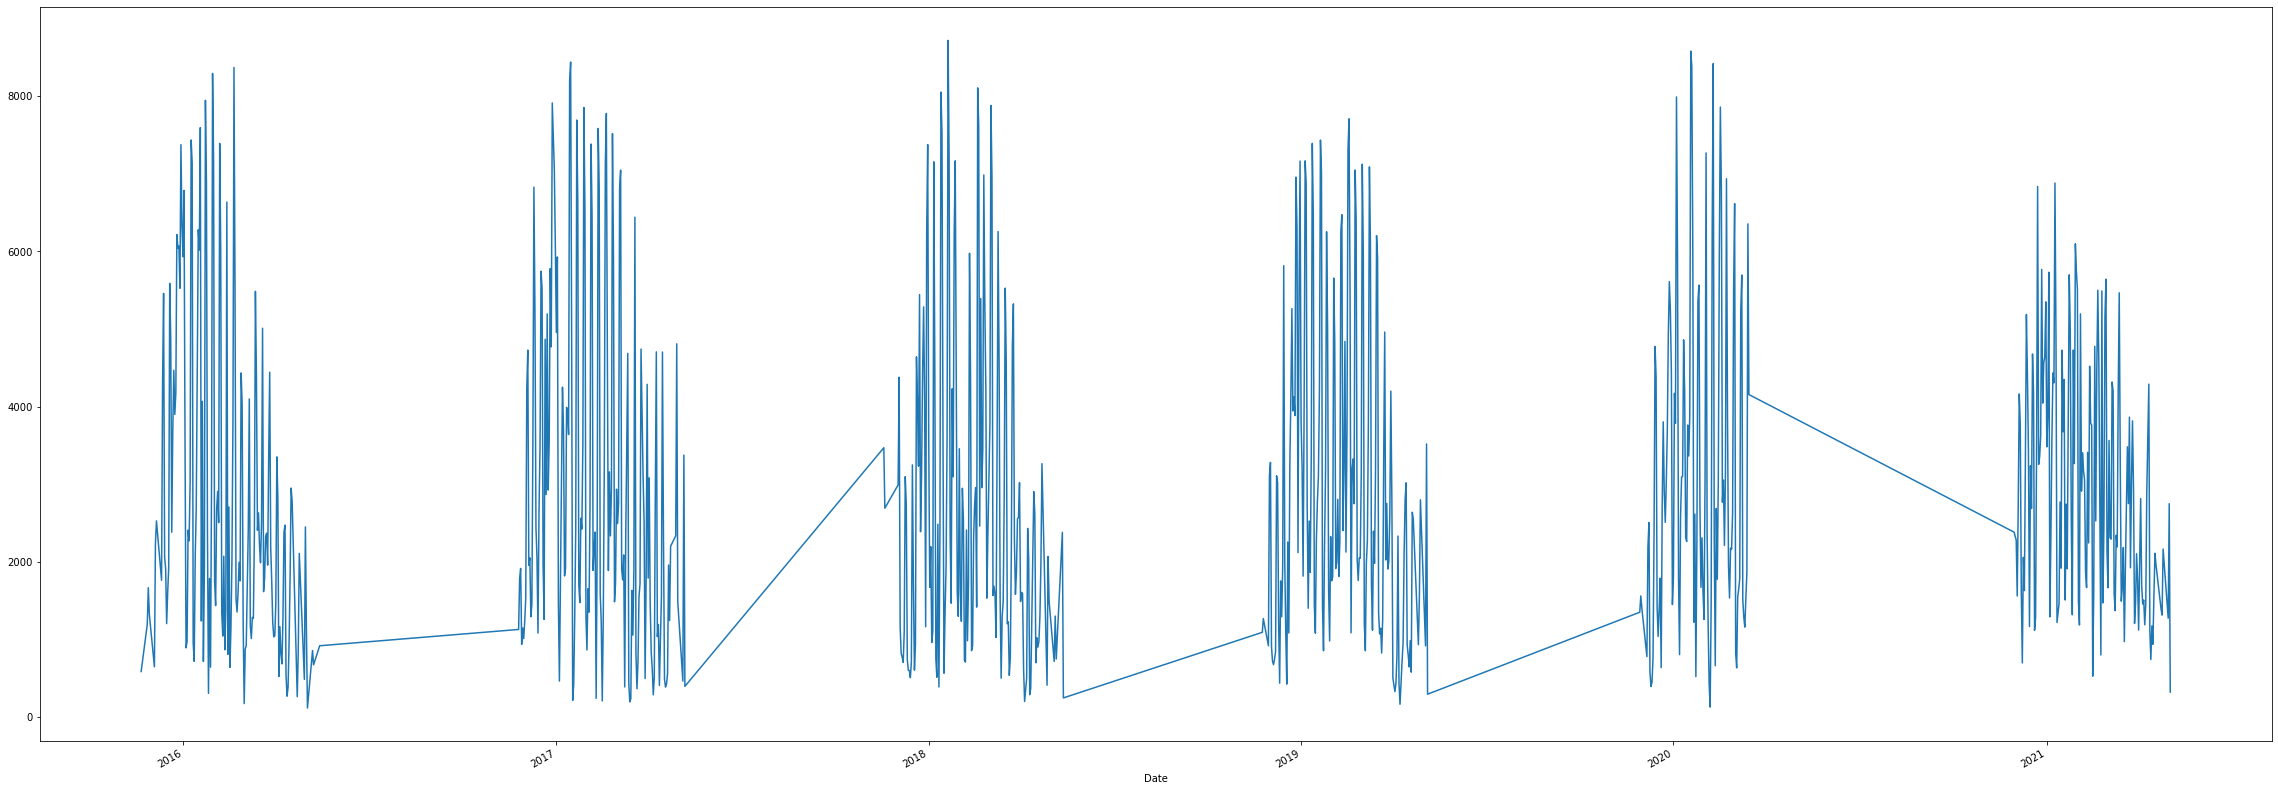

In [144]:
#Visualzing visits over time

df_3_preprocessed['TOTAL_VISITS'].plot(figsize = (40, 15));

## Some More Visualizations: Boxplot

This basic Boxplots, or sometimes called a box-and-whisker plot, is helpful to visualize distributions of our visitation data. The box shows the quartiles of the data and whiskers extend to show the rest of the distribution. It's helpful to see how the data is distributed. 

Month
1     3096.0
2     2630.0
3     2168.0
4     1275.0
5      804.0
11    1299.0
12    3005.5
Name: TOTAL_VISITS, dtype: float64


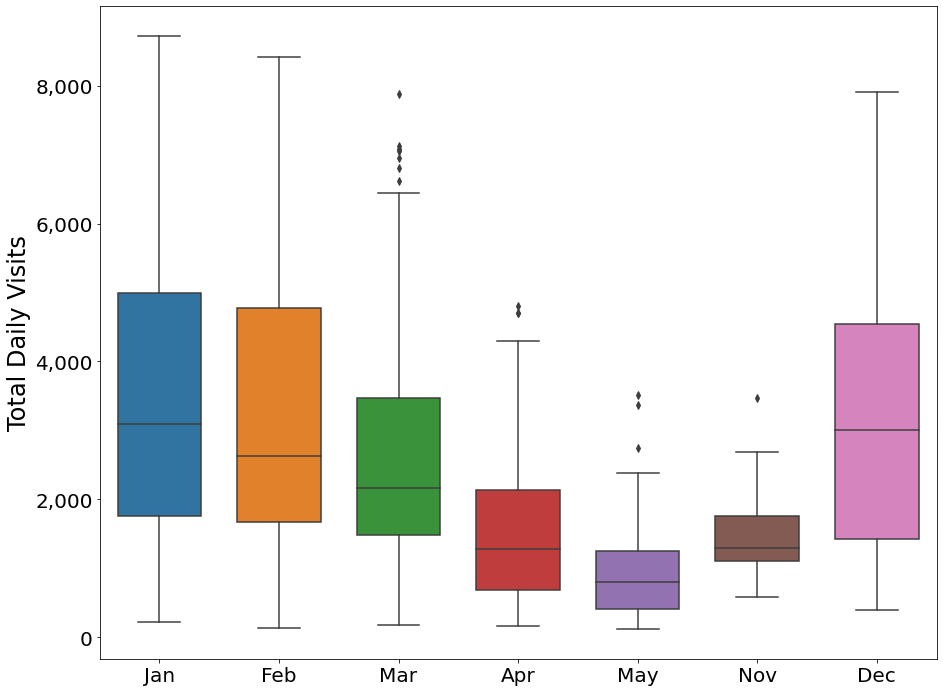

In [145]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x='Month', y='TOTAL_VISITS', data=df_3_preprocessed, width=.7)

medians = df_3_preprocessed.groupby(['Month'])['TOTAL_VISITS'].median()
print(medians)

ax.set_xlabel("")

ax.set_ylabel("Total Daily Visits", fontsize=24)

plt.yticks(fontsize=20)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Nov', 'Dec'], fontsize=20)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


plt.savefig('Visuals/resort2visits.png', dpi=300);

Let's look at the relationship between visitors and Precipitation on the Mountain: 

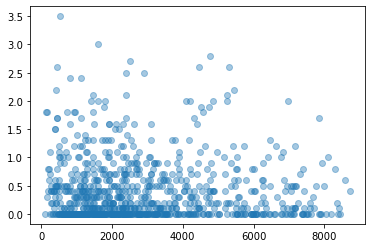

In [146]:
plt.scatter(y=df_3_preprocessed['M_PRCP'], x=df_3_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort2precip.png', dpi=300);

What about snow depth?

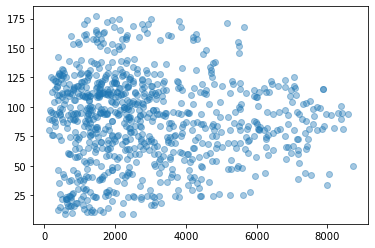

In [147]:
plt.scatter(y=df_3_preprocessed['M_SNWD'], x=df_3_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort2townprecip.png', dpi=300);

At first glance, calendar events seem to have more impact on visitation: 

IS_HOLIDAY
0    2801.304294
1    4411.944444
Name: TOTAL_VISITS, dtype: float64
SCHOOL_OUT
0    2764.799731
1    3597.028037
Name: TOTAL_VISITS, dtype: float64


<AxesSubplot:xlabel='M_PRCP', ylabel='TOTAL_VISITS'>

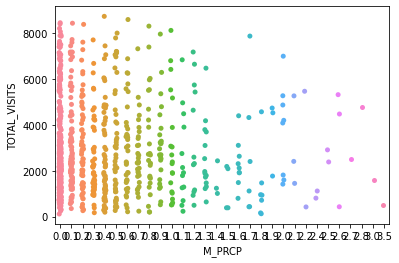

In [148]:
Holiday_averages=df_3_preprocessed.groupby(df_3_preprocessed['IS_HOLIDAY'])['TOTAL_VISITS'].mean()
print(Holiday_averages)

Schoolout_averages=df_3_preprocessed.groupby(df_3_preprocessed['SCHOOL_OUT'])['TOTAL_VISITS'].mean()
print(Schoolout_averages)

fig, ax = plt.subplots()
sns.stripplot(x='M_PRCP', y='TOTAL_VISITS', data=df_3_preprocessed)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/

<AxesSubplot:xlabel='day_of_week_num', ylabel='TOTAL_VISITS'>

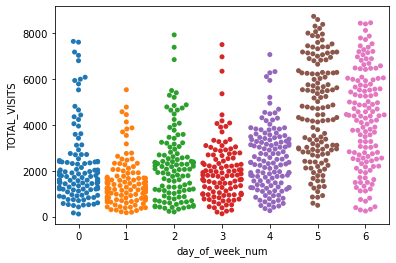

In [149]:
fig, ax = plt.subplots()
sns.swarmplot(x='day_of_week_num', y='TOTAL_VISITS', data=df_3_preprocessed)

# First Simple Model
Linear Regression

In [167]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
y.head()

Date
2015-11-21     588
2015-11-27    1196
2015-11-28    1668
2015-11-29    1328
2015-12-04     648
Name: TOTAL_VISITS, dtype: int64

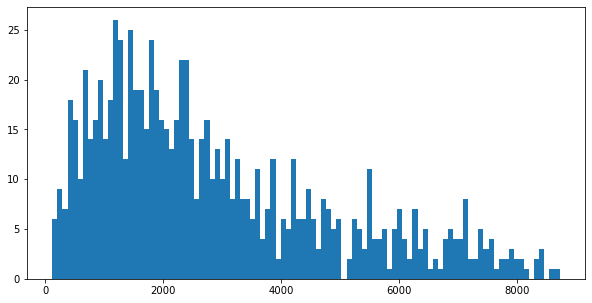

In [152]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=100);

In [153]:
#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [172]:
from sklearn.model_selection import cross_validate

cv = cross_validate(linreg, X_train, y_train, return_train_score=True)

In [173]:
#Diagnose bias vs variance with mean test and train score
cv

{'fit_time': array([0.02055931, 0.01131177, 0.02478313, 0.01276922, 0.00693083]),
 'score_time': array([0.00879884, 0.00501299, 0.00463319, 0.00247216, 0.00739026]),
 'test_score': array([0.57242504, 0.46179001, 0.42984799, 0.44936327, 0.40957171]),
 'train_score': array([0.4655157 , 0.49654377, 0.50241337, 0.49402583, 0.50436512])}

In [154]:
# Print R-Squared and RMSE

from sklearn.metrics import mean_squared_error

# Generate predictions using baseline_model and X_train
y_pred_baseline = linreg.predict(X_train)
print('Training R-Squared:', linreg.score(X_train, y_train))
print('Test R-Squared:', linreg.score(X_test, y_test))
baseline_rmse = mean_squared_error(y_train, y_pred_baseline, squared=False)
baseline_rmse

Training R-Squared: 0.48684185008707603
Test R-Squared: 0.5191936273258474


1419.7259095226495

In [155]:
# # Get the cross validated scores for our baseline model
# baseline_cv = cross_val_score(linreg, X_train, y_train, scoring="neg_root_mean_squared_error")

# # Display the average of the cross-validated scores
# baseline_cv_rmse = -(baseline_cv.mean())
# baseline_cv_rmse

# model with OHE and Standard Scaler in a pipeline

In [156]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')


LinRegPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LinRegPipe.fit(X_train, y_train)

X_test.isna().sum()

# Generate predictions using baseline_model and X_train
y_pred_LinRegPipe = LinRegPipe.predict(X_train)
y_pred_linRegPipeTest = LinRegPipe.predict(X_test)
print('Training R-Squared:', LinRegPipe.score(X_train, y_train))
print('Test R-Squared:', LinRegPipe.score(X_test, y_test))
LinRegPipe_rmse = mean_squared_error(y_train, y_pred_baseline, squared=False)
LinRegPipe_rmse

Training R-Squared: 0.6784550333455129
Test R-Squared: 0.690765031619305


1419.7259095226495

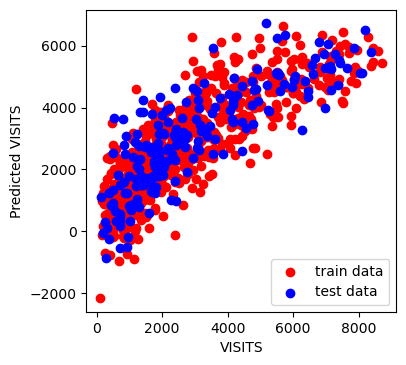

In [157]:
plt.figure(figsize=(4, 4), dpi=100)
plt.xlabel("VISITS")
plt.ylabel("Predicted VISITS")
# plt.xlim(0, 60)
# plt.ylim(0, 60)
plt.scatter(y_train, y_pred_LinRegPipe, lw=1, color="r", label="train data")
plt.scatter(y_test, y_pred_linRegPipeTest, lw=1, color="b", label="test data")
plt.legend()
plt.show()

## Tree Regressor

In [158]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')


TreeRegPipe = Pipeline([('trans', Transformer),
                        ('treereg', DecisionTreeRegressor())])

TreeRegPipe.fit(X_train, y_train)

y_pred_tree = TreeRegPipe.predict(X_train)
print('Training R-Squared:', TreeRegPipe.score(X_train, y_train))
print('Test R-Squared:', TreeRegPipe.score(X_test, y_test))
TreeRegPipe_rmse = mean_squared_error(y_train, y_pred_tree, squared=False)
TreeRegPipe_rmse



Training R-Squared: 1.0
Test R-Squared: 0.4790984344461301


0.0

# ##Decision tree is probably overfitting up there, let's do a grid search: 

In [159]:
#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf2 = DecisionTreeRegressor(random_state = 42)

#pipeline
pipeline_2 = Pipeline([('transformer', Transformer),
						('dtr', dt_clf2)])

#set up grid search paramater grid
dt_param_grid = {
    'dtr__min_samples_split': [2, 4, 6, 8],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6]
}

#set up gridsearch:
gridsearch = GridSearchCV(estimator=pipeline_2,
						  param_grid=dt_param_grid,
						  cv=5)


#fit gridsearch
gridsearch.fit(X_train, y_train)

# Print the accuracy on test set
gridsearch.score(X_test, y_test)

gridsearch_opt_tree = gridsearch.predict(X_train)
print('Training R-Squared:', gridsearch.score(X_train, y_train))
print('Test R-Squared:', gridsearch.score(X_test, y_test))
print("Best Parameter Combination Found During Grid Search:")
print(gridsearch.best_params_)
opt_tree_rmse = mean_squared_error(y_train, gridsearch_opt_tree, squared=False)
opt_tree_rmse

Training R-Squared: 0.7801445335595596
Test R-Squared: 0.5336154915429109
Best Parameter Combination Found During Grid Search:
{'dtr__max_depth': 6, 'dtr__min_samples_split': 8}


929.2820040529152

## Wanna try Random Forests? 

In [160]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch2 = GridSearchCV(estimator=pipeline_3,
						  param_grid=rfr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch2.fit(X_train, y_train)

# Print the accuracy on test set
gridsearch2.score(X_test, y_test)

gridsearch2_opt_forest = gridsearch2.predict(X_train)
print('Training R-Squared:', gridsearch2.score(X_train, y_train))
print('Test R-Squared:', gridsearch2.score(X_test, y_test))
print("Best Parameter Combination Found During Grid Search:")
print(gridsearch2.best_params_)
opt_tree_rmse = mean_squared_error(y_train, gridsearch2_opt_forest, squared=False)
opt_tree_rmse

Training R-Squared: 0.9301102687947825
Test R-Squared: 0.668594321761777
Best Parameter Combination Found During Grid Search:
{'dtr__criterion': 'mse', 'dtr__max_depth': 10, 'dtr__max_features': 'auto', 'dtr__n_estimators': 16}


523.9448523689429

For this dataset, forests are performing better than trees

In [161]:
y_pred = gridsearch2.predict(X_test)

df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df

,Real Values,Predicted Values
Date,,
2016-02-08,1349,1846.820402
2017-12-14,509,819.864322
2020-01-26,5566,2535.083333
2021-03-01,2141,1849.074974
2018-03-06,1687,1784.048858
...,...,...
2020-02-28,2630,2363.429936
2017-12-26,4444,4724.236458
2018-04-07,496,3575.937500


Gradient Boosting: 

In [162]:
from sklearn.ensemble import GradientBoostingRegressor

#pipeline_4:

#Split into test and train X and Y
X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(random_state = 42)

#pipeline
pipeline_4 = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae']
}

#set up gridsearch:
gridsearch3 = GridSearchCV(estimator=pipeline_4,
						  param_grid=gbr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch3.fit(X_train, y_train)

# Print the accuracy on test set
gridsearch3.score(X_test, y_test)

gridsearch3_opt = gridsearch3.predict(X_train)
print('Training R-Squared:', gridsearch3.score(X_train, y_train))
print('Test R-Squared:', gridsearch3.score(X_test, y_test))
print("Best Parameter Combination Found During Grid Search:")
print(gridsearch3.best_params_)
opt_gbr_rmse = mean_squared_error(y_train, gridsearch3_opt, squared=False)
opt_gbr_rmse


Training R-Squared: 0.9199573419226812
Test R-Squared: 0.746588562722756
Best Parameter Combination Found During Grid Search:
{'gbr__criterion': 'mse', 'gbr__n_estimators': 200}


560.7117331004602

In [163]:
from sklearn.ensemble import GradientBoostingRegressor

#pipeline_booster:

X_boost = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y_boost = df_3_preprocessed['TOTAL_VISITS']
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boost, y_boost, test_size=0.25, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(criterion= 'friedman_mse', n_estimators=100, random_state = 42)

#pipeline
pipeline_boost = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

pipeline_boost.fit(X_train_boost, y_train_boost)

# Print the accuracy on test set
print(pipeline_boost.score(X_test_boost, y_test_boost))

boost_pred = pipeline_boost.predict(X_train_boost)
print('Training R-Squared:', pipeline_boost.score(X_train_boost, y_train_boost))
print('Test R-Squared:', pipeline_boost.score(X_test_boost, y_test_boost))

boost_rmse = mean_squared_error(y_train_boost, gridsearch3_opt, squared=False)
boost_rmse

0.7341703012634228
Training R-Squared: 0.8655990699805461
Test R-Squared: 0.7341703012634228


560.7117331004602

In [164]:
y_pred_boost = pipeline_boost.predict(X_test_boost)

df = pd.DataFrame({'Real Visits':y_test_boost, 'Predicted Visits':y_pred_boost, 'Difference': abs(y_test_boost - y_pred_boost)})
df

,Real Visits,Predicted Visits,Difference
Date,,,
2016-02-08,1349,1647.445070,298.445070
2017-12-14,509,593.941888,84.941888
2020-01-26,5566,3652.370131,1913.629869
2021-03-01,2141,1517.529187,623.470813
2018-03-06,1687,2155.026688,468.026688
...,...,...,...
2020-02-28,2630,1914.387231,715.612769
2017-12-26,4444,4331.405455,112.594545
2018-04-07,496,2049.102036,1553.102036


In [165]:
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor

#pipeline_4:

X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_3_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Pipeline first step: Transformer

cat = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat = ['M_PRCP',	'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# #set up grid search paramater grid
# gbr_param_grid = {
#     'gbr__n_estimators': [50, 100, 200, 300],
#     'gbr__criterion': ['friedman_mse', 'mse', 'mae']
# }

# #set up gridsearch:
# gridsearch3 = GridSearchCV(estimator=pipeline_4,
# 						  param_grid=gbr_param_grid,
# 						  cv=5)


#fit gridsearch
xboostPipe.fit(X_train, y_train)

# Print the accuracy on test set
xboostPipe.score(X_test, y_test)

xboost_pred = xboostPipe.predict(X_train)
print('Training R-Squared:', xboostPipe.score(X_train, y_train))
print('Test R-Squared:', xboostPipe.score(X_test, y_test))
# print("Best Parameter Combination Found During Grid Search:")
# print(gridsearch3.best_params_)
xboost_rmse = mean_squared_error(y_train, xboost_pred, squared=False)
xboost_rmse


Training R-Squared: 0.9105103252954447
Test R-Squared: 0.6773153958654436


592.8780304028435

In [166]:
y_pred = gridsearch2.predict(X_test)

df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred, 'Difference': abs(y_test - y_pred)})
df

,Real Values,Predicted Values,Difference
Date,,,
2016-02-08,1349,1846.820402,497.820402
2017-12-14,509,819.864322,310.864322
2020-01-26,5566,2535.083333,3030.916667
2021-03-01,2141,1849.074974,291.925026
2018-03-06,1687,1784.048858,97.048858
...,...,...,...
2020-02-28,2630,2363.429936,266.570064
2017-12-26,4444,4724.236458,280.236458
2018-04-07,496,3575.937500,3079.937500
